In [ ]:
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 4.9 MB/s 
     |████████████████████████████████| 1.5 MB 37.2 MB/s 
     |████████████████████████████████| 1.6 MB 34.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616826 sha256=678b24ed070f6832d627f5d46e84339cacc2f2c56b864f6646a7ee0786648f7d
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=eef3454fda2322e4b0559ed86afef22207498244ee9940eb5dd43bf717ca5a65
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built gym AutoROM.accept-rom-license


In [ ]:
!pip install gym
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.6 kB/s 
     |████████████████████████████████| 8.8 MB 55.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.2.0+cu92 which is

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F

from stable_baselines3 import A2C, PPO, DDPG, SAC, TD3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box, Dict
from typing import Optional # For reset()
import numpy as np
import random
import pandas as pd

In [ ]:
def standardize_reward(rew, rew_list):
  epsilon = float(1e-8)
  rew_array = np.array(rew_list)
  final_rew = (rew - rew_array.mean())/(np.sqrt(rew_array.var()+epsilon))
  return final_rew

def normalize_reward(rew, rew_list):
  # normalize reward to [-1,0]
  epsilon = float(1e-8)
  if len(rew_list) <= 1:
    return np.array([-1])
  rew_array = np.array(rew_list)
  final_rew = (rew - rew_array.min())/(rew_array.max()-rew_array.min()) - 1
  return final_rew


In [ ]:
# WithOUT agents prev prediction as observation!
# Dataset should contain 8 columns (excluding the date column)
class NFT_Price_Gym(Env):
  def __init__(self, file_directory, train=False):
  # def __init__(self, basic_data, external_data,  train=False): 
    # processing the data
    df = pd.read_csv(file_directory).iloc[:, 1:]
    self.df = df
    self.train = train

    # array of min and max values for each feature
    min = df.describe().iloc[3,:]
    max = df.describe().iloc[7,:]
    max_price = df.describe().iloc[7,1]
    # low_obs_target = np.zeros(7)
    high_obs_target = 3*np.array(max)
    high_obs_price = 3*np.array([max_price])

    low_obs_final = np.zeros(8)
    high_obs_final = high_obs_target
   
    
    self.total_timesteps = df.shape[0]
    # Use 3/4 of the total data when training
    if train:
      self.total_timesteps *= 0.75
    self.current_timestep = 0

    # Observation space: bound for each feature dimension (first index is the agent prediction of Avg USD)
    self.observation_space = Box(low_obs_final, high_obs_final, shape=(8,), dtype=np.float32)
    
    # for normalizing
    self.action_list = [0.]
    self.obs_list=[]
    self.rew_list=[]

    # Action space: value for agent to go up or down by. Normalized to a range of [-1, 1]
    self.action_space = Box(low=np.array([-50000]), 
                            high=np.array([50000]),
                            dtype=np.float32)

  # For convenience, define a method that translates the current state to observation, agent: Avg USD, target:
  def get_obs(self):
    return self.target_location
  
  def get_error(self):
    return np.absolute(self.target_location[1] - self.agent_prediction)

  def reset(self, *, seed: Optional[int] = None, return_info=False):
    # random seed
    #super().reset(seed=seed)
    
    self.current_timestep = 0
    
    #initialize the variables with the first observed price value
    self.agent_location = np.array([self.df.iloc[0][1]]) 
    self.agent_prediction = np.array([self.df.iloc[0][1]])
    self.target_location = np.array(self.df.iloc[0])

    observation = self.get_obs()
    self.obs_list.append(observation)

    info = {}
    return (observation, info) if return_info else observation

  def step(self, action):
    epsilon = float(1e-8)

    self.current_timestep += 1

    # next prediction will be in range of 0.5~1.5 times the current price, adjust ratio for more volatility
    self.agent_prediction = self.agent_location * (1 + (0.5*action))
    
    self.target_location = np.array(self.df.iloc[self.current_timestep])
    
    observation = self.get_obs()
    self.obs_list.append(observation)
    
    error = self.get_error()
    reward = -error[0]
    self.rew_list.append(reward)

    # reward = standardize_reward(reward, self.rew_list)    
    reward = normalize_reward(reward, self.rew_list).item()

    # episode finished if the timestep reaches the total timestep
    done = self.current_timestep >= self.total_timesteps-1

    # update agent_location for next prediction
    self.agent_location = self.target_location[1]
    return observation, reward, done, {}

  def render(self): # for visualization
    pass

In [ ]:
# # step first
# # Dataset should contain 8 columns (excluding the date column)
# class NFT_Price_Gym(Env):
#   def __init__(self, file_directory, train=False):
#   # def __init__(self, basic_data, external_data,  train=False): 
#     # processing the data
#     df = pd.read_csv(file_directory).iloc[:, 1:]
#     self.df = df
#     self.train = train

#     # array of min and max values for each feature
#     min = df.describe().iloc[3,:]
#     max = df.describe().iloc[7,:]
#     max_price = df.describe().iloc[7,1]
#     # low_obs_target = np.zeros(7)
#     high_obs_target = 3*np.array(max)
#     high_obs_price = 3*np.array([max_price])

#     low_obs_final = np.zeros(8)
#     high_obs_final = high_obs_target
   
    
#     self.total_timesteps = df.shape[0]
#     # Use 3/4 of the total data when training
#     if train:
#       self.total_timesteps *= 0.75
#     self.current_timestep = 0

#     # Observation space: bound for each feature dimension (first index is the agent prediction of Avg USD)
#     self.observation_space = Box(low_obs_final, high_obs_final, shape=(8,), dtype=np.float32)
    
#     # for normalizing
#     self.action_list = [0.]
#     self.obs_list=[]
#     self.rew_list=[]

#     # Action space: value for agent to go up or down by. Normalized to a range of [-1, 1]
#     self.action_space = Box(low=np.array([-50000]), 
#                             high=np.array([50000]),
#                             dtype=np.float32)

#   # For convenience, define a method that translates the current state to observation, agent: Avg USD, target:
#   def get_obs(self):
#     return self.target_location
  
#   def get_error(self):
#     return np.absolute(self.target_location[1] - self.agent_prediction)

#   def reset(self, *, seed: Optional[int] = None, return_info=False):
#     # random seed
#     #super().reset(seed=seed)
    
#     self.current_timestep = 1
    
#     #initialize the variables with the first observed price value
#     self.agent_location = np.array([self.df.iloc[0][1]]) 
#     self.agent_prediction = np.array([self.df.iloc[0][1]])
#     self.target_location = np.array(self.df.iloc[0])

#     observation = self.get_obs()
#     self.obs_list.append(observation)

#     info = {}
#     return (observation, info) if return_info else observation

#   def step(self, action):
#     epsilon = float(1e-8)

#     # next prediction will be in range of 0.5~1.5 times the current price, adjust ratio for more volatility
#     self.agent_prediction = self.agent_location * (1 + (0.5*action))
    
#     self.target_location = np.array(self.df.iloc[self.current_timestep])
  
    
#     observation = self.get_obs()
#     self.obs_list.append(observation)
    
#     error = self.get_error()
#     reward = -error[0]
#     self.rew_list.append(reward)

#     # reward = standardize_reward(reward, self.rew_list)    
#     reward = normalize_reward(reward, self.rew_list).item()

#     # episode finished if the timestep reaches the total timestep
#     self.current_timestep += 1
#     done = self.current_timestep >= self.total_timesteps-1

#     # update agent_location for next prediction
#     self.agent_location = self.target_location[1]
#     return observation, reward, done, {}

#   def render(self): # for visualization
#     pass

In [ ]:
checkpoint = False
import os
from tqdm.notebook import tqdm

# Callback function to save best model
class SaveonBestandProgressBar(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1, prev_timesteps = 0):
        super(SaveonBestandProgressBar, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        self.pbar = None
        self.reward_list = []
        self.prev_timesteps = prev_timesteps

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_training_start(self):
        factor = np.ceil(self.locals['total_timesteps'] / self.model.n_steps)
        n = 1
        try:
            n = len(self.training_env.envs)
        except AttributeError:
            try:
                n = len(self.training_env.remotes)
            except AttributeError:
                n = 1
        total = int(self.model.n_steps * factor / n)
        self.pbar = tqdm(total=total)

    def _on_rollout_start(self):
        self.pbar.refresh()
    
    def _on_step(self):
        # plot the average reward of the last 100 episodes
        if self.n_calls % 100 == 0:
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              mean_reward = np.mean(y[-100:])
              self.reward_list.append(mean_reward)
        self.pbar.update(1)
        if self.n_calls % self.check_freq == 0:
          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps + self.prev_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  self.save_path = os.path.join(log_dir, '{}'.format(self.prev_timesteps + self.num_timesteps), 'best_model')
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

    def _on_rollout_end(self):
        self.pbar.refresh()

    def _on_training_end(self):
        self.pbar.close()
        self.pbar = None



In [ ]:
data_file_directory_1 = '/content/drive/MyDrive/NFT Prediction/bored_ape_FINAL.csv'

filepath = "/content/drive/My Drive/NFT Prediction/training/bored ape"
experiment = "agent_PPO_REALFINAL"
log_dir = f"{filepath}/{experiment}"
file_directory = log_dir + '/best_model.zip'

train_env = NFT_Price_Gym(data_file_directory_1, train=True)
train_env = Monitor(train_env, log_dir)

Callbacktinst = SaveonBestandProgressBar(check_freq=2000, log_dir=log_dir)
# The default MlpPolicy of SB3 for PPO and A2C uses tanh as its activation function
model = PPO("MlpPolicy", train_env, verbose=2)
num_timesteps = 1.5e5
model.learn(num_timesteps, callback=Callbacktinst, eval_freq=1000, log_interval=1000)

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


Using cpu device
Wrapping the env in a DummyVecEnv.


  0%|          | 0/151552 [00:00<?, ?it/s]

Num timesteps: 2000
Best mean reward: -inf - Last mean reward per episode: -41.65
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/2000/best_model
Num timesteps: 4000
Best mean reward: -41.65 - Last mean reward per episode: -34.96
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/4000/best_model
Num timesteps: 6000
Best mean reward: -34.96 - Last mean reward per episode: -32.71
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/6000/best_model
Num timesteps: 8000
Best mean reward: -32.71 - Last mean reward per episode: -31.47
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/8000/best_model
Num timesteps: 10000
Best mean reward: -31.47 - Last mean reward per episode: -30.45
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/10

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/62000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 64000
Best mean reward: -19.72 - Last mean reward per episode: -19.58
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/64000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/64000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 66000
Best mean reward: -19.58 - Last mean reward per episode: -19.43
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/66000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/66000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 68000
Best mean reward: -19.43 - Last mean reward per episode: -19.29
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/68000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/68000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 70000
Best mean reward: -19.29 - Last mean reward per episode: -19.16
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/70000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/70000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 72000
Best mean reward: -19.16 - Last mean reward per episode: -19.02
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/72000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/72000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 74000
Best mean reward: -19.02 - Last mean reward per episode: -18.90
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/74000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/74000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 76000
Best mean reward: -18.90 - Last mean reward per episode: -18.80
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/76000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/76000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 78000
Best mean reward: -18.80 - Last mean reward per episode: -18.71
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/78000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/78000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 80000
Best mean reward: -18.71 - Last mean reward per episode: -18.61
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/80000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/80000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 82000
Best mean reward: -18.61 - Last mean reward per episode: -18.47
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/82000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/82000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 84000
Best mean reward: -18.47 - Last mean reward per episode: -18.33
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/84000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/84000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 86000
Best mean reward: -18.33 - Last mean reward per episode: -18.21
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/86000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/86000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 88000
Best mean reward: -18.21 - Last mean reward per episode: -18.13
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/88000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/88000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 90000
Best mean reward: -18.13 - Last mean reward per episode: -18.06
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/90000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/90000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 92000
Best mean reward: -18.06 - Last mean reward per episode: -18.01
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/92000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/92000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 94000
Best mean reward: -18.01 - Last mean reward per episode: -17.89
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/94000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/94000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 96000
Best mean reward: -17.89 - Last mean reward per episode: -17.80
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/96000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/96000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 98000
Best mean reward: -17.80 - Last mean reward per episode: -17.71
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/98000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/98000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 100000
Best mean reward: -17.71 - Last mean reward per episode: -17.68
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/100000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/100000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 102000
Best mean reward: -17.68 - Last mean reward per episode: -17.63
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/102000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/102000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 104000
Best mean reward: -17.63 - Last mean reward per episode: -17.56
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/104000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/104000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 106000
Best mean reward: -17.56 - Last mean reward per episode: -17.49
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/106000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/106000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 108000
Best mean reward: -17.49 - Last mean reward per episode: -17.43
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/108000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/108000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 110000
Best mean reward: -17.43 - Last mean reward per episode: -17.37
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/110000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/110000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 112000
Best mean reward: -17.37 - Last mean reward per episode: -17.34
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/112000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/112000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 114000
Best mean reward: -17.34 - Last mean reward per episode: -17.33
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/114000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/114000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 116000
Best mean reward: -17.33 - Last mean reward per episode: -17.23
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/116000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/116000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 118000
Best mean reward: -17.23 - Last mean reward per episode: -17.13
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/118000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/118000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 120000
Best mean reward: -17.13 - Last mean reward per episode: -17.00
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/120000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/120000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 122000
Best mean reward: -17.00 - Last mean reward per episode: -16.92
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/122000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/122000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 124000
Best mean reward: -16.92 - Last mean reward per episode: -16.89
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/124000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/124000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 126000
Best mean reward: -16.89 - Last mean reward per episode: -16.79
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/126000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/126000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 128000
Best mean reward: -16.79 - Last mean reward per episode: -16.68
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/128000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/128000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 130000
Best mean reward: -16.68 - Last mean reward per episode: -16.55
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/130000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/130000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 132000
Best mean reward: -16.55 - Last mean reward per episode: -16.45
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/132000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/132000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 134000
Best mean reward: -16.45 - Last mean reward per episode: -16.44
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/134000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/134000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 136000
Best mean reward: -16.44 - Last mean reward per episode: -16.35
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/136000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/136000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 138000
Best mean reward: -16.35 - Last mean reward per episode: -16.25
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/138000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/138000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 140000
Best mean reward: -16.25 - Last mean reward per episode: -16.20
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/140000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/140000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 142000
Best mean reward: -16.20 - Last mean reward per episode: -16.12
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/142000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/142000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 144000
Best mean reward: -16.12 - Last mean reward per episode: -16.05
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/144000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/144000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 146000
Best mean reward: -16.05 - Last mean reward per episode: -16.03
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/146000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/146000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 148000
Best mean reward: -16.03 - Last mean reward per episode: -15.98
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/148000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/148000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 150000
Best mean reward: -15.98 - Last mean reward per episode: -15.96
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/150000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/150000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [ ]:
# # additional training
# file_directory = '/content/drive/My Drive/NFT Prediction/training/agent_PPO/best_model.zip'
# model = PPO.load(file_directory, train_env)

# num_timesteps = 1e5
# model.learn(num_timesteps, callback=Callbacktinst, eval_freq=1000, log_interval=1000)


/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


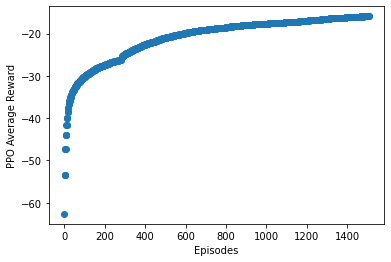

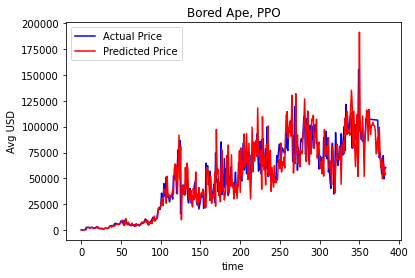

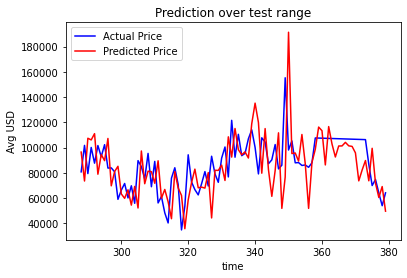

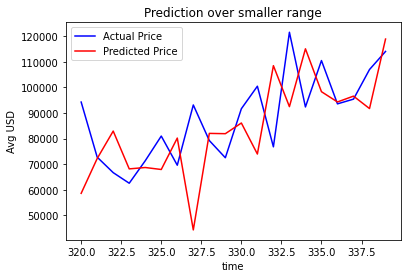

In [ ]:
import matplotlib.pyplot as plt

data_file_directory_1 = '/content/drive/MyDrive/NFT Prediction/bored_ape_FINAL.csv'
test_env = NFT_Price_Gym(data_file_directory_1, train=False)
file_directory = '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_PPO_REALFINAL/150000/best_model.zip'
model = PPO.load(file_directory, test_env)

# Plotting Average Reward throughout training
reward_list = Callbacktinst.reward_list[5:]
rewards = np.array(reward_list)
episodes= np.array(range(len(reward_list)))
plt.scatter(episodes, rewards)
plt.xlabel('Episodes')
plt.ylabel('PPO Average Reward')
plt.show()

obs = test_env.reset()

done = False
pred_list = []
gt_list = []

while not done:
    action, _ = model.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    prediction = test_env.agent_prediction
    pred_list.append(prediction)
    gt = obs[1]
    gt_list.append(gt)

# Plotting prediction over total range
time1 = np.array(range(len(gt_list)))

plt.plot(time1, gt_list, color='blue', label='Actual Price')
plt.plot(time1, pred_list, color='red', label='Predicted Price')
plt.title('Bored Ape, PPO')
plt.xlabel('time')
plt.ylabel('Avg USD')
plt.legend()
plt.show()

# Plotting over test range
tot_time = len(gt_list)
plot_range = int(tot_time*0.24)
start = int(tot_time*0.75)
time = start + np.array(range(plot_range))

plt.plot(time, gt_list[start:start+plot_range], color='blue', label='Actual Price')
plt.plot(time, pred_list[start:start+plot_range], color='red', label='Predicted Price')
plt.title('Prediction over test range')
plt.xlabel('time')
plt.ylabel('Avg USD')
plt.legend()
plt.show()

# Plotting over smaller range
plot_range = 20
start = 320
time = start + np.array(range(plot_range))

plt.plot(time, gt_list[start:start+plot_range], color='blue', label='Actual Price')
plt.plot(time, pred_list[start:start+plot_range], color='red', label='Predicted Price')
plt.title('Prediction over smaller range')
plt.xlabel('time')
plt.ylabel('Avg USD')
plt.legend()
plt.show()

In [ ]:
# Finding RMSE and R2
from sklearn.metrics import mean_squared_error, r2_score

start_index = int(tot_time*0.75)
RMSE = mean_squared_error(gt_list[start_index:], pred_list[start_index:], squared=False)
R2 = r2_score(gt_list[start_index:], pred_list[start_index:])

print('Bored Ape, PPO')
print('RMSE: {}'.format(RMSE))
print('R2: {}'.format(R2))

Bored Ape, PPO
RMSE: 24591.03612437197
R2: -0.5160699376353339


In [ ]:
# A2C

filepath = "/content/drive/My Drive/NFT Prediction/training/bored ape"
experiment = "agent_A2C_FINAL"
log_dir = f"{filepath}/{experiment}"
file_directory = log_dir + '/best_model.zip'

train_env = NFT_Price_Gym(data_file_directory_1, train=True)
train_env = Monitor(train_env, log_dir)

Callbacktinst = SaveonBestandProgressBar(check_freq=2000, log_dir=log_dir)

model = A2C("MlpPolicy", train_env, verbose=2)
num_timesteps = 1.5e5
model.learn(num_timesteps, callback=Callbacktinst, eval_freq=1000, log_interval=1000)

Using cpu device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


  0%|          | 0/150000 [00:00<?, ?it/s]

Num timesteps: 2000
Best mean reward: -inf - Last mean reward per episode: -52.74
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/2000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/2000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 4000
Best mean reward: -52.74 - Last mean reward per episode: -41.59
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/4000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/4000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -38.7    |
| time/                 |          |
|    fps                | 221      |
|    iterations         | 1000     |
|    time_elapsed       | 22       |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -1.17    |
|    explained_variance | 0.43     |
|    learning_rate      | 0.0007   |
|    n_updates          | 999      |
|    policy_loss        | -0.053   |
|    std                | 0.776    |
|    value_loss         | 0.00553  |
------------------------------------
Num timesteps: 6000
Best mean reward: -41.59 - Last mean reward per episode: -36.44
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/6000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/6000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 8000
Best mean reward: -36.44 - Last mean reward per episode: -32.61
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/8000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/8000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 10000
Best mean reward: -32.61 - Last mean reward per episode: -30.43
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/10000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -30.4    |
| time/                 |          |
|    fps                | 192      |
|    iterations         | 2000     |
|    time_elapsed       | 51       |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -1       |
|    explained_variance | -0.345   |
|    learning_rate      | 0.0007   |
|    n_updates          | 1999     |
|    policy_loss        | -0.378   |
|    std                | 0.658    |
|    value_loss         | 0.193    |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/10000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 12000
Best mean reward: -30.43 - Last mean reward per episode: -28.78
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/12000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/12000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 14000
Best mean reward: -28.78 - Last mean reward per episode: -27.59
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/14000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/14000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -27      |
| time/                 |          |
|    fps                | 174      |
|    iterations         | 3000     |
|    time_elapsed       | 86       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -0.827   |
|    explained_variance | -1.12    |
|    learning_rate      | 0.0007   |
|    n_updates          | 2999     |
|    policy_loss        | 0.245    |
|    std                | 0.554    |
|    value_loss         | 0.0396   |
------------------------------------
Num timesteps: 16000
Best mean reward: -27.59 - Last mean reward per episode: -26.59
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/16000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/16000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 18000
Best mean reward: -26.59 - Last mean reward per episode: -25.76
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/18000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/18000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 20000
Best mean reward: -25.76 - Last mean reward per episode: -25.05
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/20000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -25      |
| time/                 |          |
|    fps                | 159      |
|    iterations         | 4000     |
|    time_elapsed       | 125      |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -0.686   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | -0.0988  |
|    std                | 0.48     |
|    value_loss         | 0.00727  |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/20000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 22000
Best mean reward: -25.05 - Last mean reward per episode: -24.42
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/22000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/22000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 24000
Best mean reward: -24.42 - Last mean reward per episode: -23.89
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/24000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/24000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -23.7    |
| time/                 |          |
|    fps                | 146      |
|    iterations         | 5000     |
|    time_elapsed       | 170      |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -0.569   |
|    explained_variance | -0.51    |
|    learning_rate      | 0.0007   |
|    n_updates          | 4999     |
|    policy_loss        | 0.0178   |
|    std                | 0.427    |
|    value_loss         | 0.00607  |
------------------------------------
Num timesteps: 26000
Best mean reward: -23.89 - Last mean reward per episode: -23.42
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/26000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/26000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 28000
Best mean reward: -23.42 - Last mean reward per episode: -23.01
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/28000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/28000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 30000
Best mean reward: -23.01 - Last mean reward per episode: -21.24
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/30000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -21.2    |
| time/                 |          |
|    fps                | 135      |
|    iterations         | 6000     |
|    time_elapsed       | 221      |
|    total_timesteps    | 30000    |
| train/                |          |
|    entropy_loss       | -0.469   |
|    explained_variance | -3.49    |
|    learning_rate      | 0.0007   |
|    n_updates          | 5999     |
|    policy_loss        | 0.254    |
|    std                | 0.387    |
|    value_loss         | 0.0279   |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/30000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 32000
Best mean reward: -21.24 - Last mean reward per episode: -20.06
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/32000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/32000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 34000
Best mean reward: -20.06 - Last mean reward per episode: -19.18
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/34000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/34000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -19.1    |
| time/                 |          |
|    fps                | 126      |
|    iterations         | 7000     |
|    time_elapsed       | 276      |
|    total_timesteps    | 35000    |
| train/                |          |
|    entropy_loss       | -0.41    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 6999     |
|    policy_loss        | 0.0351   |
|    std                | 0.365    |
|    value_loss         | 0.00957  |
------------------------------------
Num timesteps: 36000
Best mean reward: -19.18 - Last mean reward per episode: -18.86
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/36000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/36000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 38000
Best mean reward: -18.86 - Last mean reward per episode: -18.56
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/38000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/38000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 40000
Best mean reward: -18.56 - Last mean reward per episode: -18.24
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/40000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -18.2    |
| time/                 |          |
|    fps                | 119      |
|    iterations         | 8000     |
|    time_elapsed       | 335      |
|    total_timesteps    | 40000    |
| train/                |          |
|    entropy_loss       | -0.311   |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 7999     |
|    policy_loss        | -0.00221 |
|    std                | 0.33     |
|    value_loss         | 0.00038  |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/40000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 42000
Best mean reward: -18.24 - Last mean reward per episode: -17.94
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/42000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/42000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 44000
Best mean reward: -17.94 - Last mean reward per episode: -17.65
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/44000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/44000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -17.5    |
| time/                 |          |
|    fps                | 112      |
|    iterations         | 9000     |
|    time_elapsed       | 398      |
|    total_timesteps    | 45000    |
| train/                |          |
|    entropy_loss       | -0.234   |
|    explained_variance | -1.28    |
|    learning_rate      | 0.0007   |
|    n_updates          | 8999     |
|    policy_loss        | 0.0121   |
|    std                | 0.306    |
|    value_loss         | 0.0394   |
------------------------------------
Num timesteps: 46000
Best mean reward: -17.65 - Last mean reward per episode: -17.42
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/46000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/46000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 48000
Best mean reward: -17.42 - Last mean reward per episode: -17.29
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/48000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/48000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 50000
Best mean reward: -17.29 - Last mean reward per episode: -17.16
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/50000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -17.2    |
| time/                 |          |
|    fps                | 106      |
|    iterations         | 10000    |
|    time_elapsed       | 468      |
|    total_timesteps    | 50000    |
| train/                |          |
|    entropy_loss       | -0.184   |
|    explained_variance | 0.083    |
|    learning_rate      | 0.0007   |
|    n_updates          | 9999     |
|    policy_loss        | -0.0405  |
|    std                | 0.291    |
|    value_loss         | 0.0467   |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/50000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 52000
Best mean reward: -17.16 - Last mean reward per episode: -17.07
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/52000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/52000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 54000
Best mean reward: -17.07 - Last mean reward per episode: -16.90
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/54000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/54000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -16.8    |
| time/                 |          |
|    fps                | 101      |
|    iterations         | 11000    |
|    time_elapsed       | 541      |
|    total_timesteps    | 55000    |
| train/                |          |
|    entropy_loss       | -0.115   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 10999    |
|    policy_loss        | 0.0419   |
|    std                | 0.272    |
|    value_loss         | 0.0525   |
------------------------------------
Num timesteps: 56000
Best mean reward: -16.90 - Last mean reward per episode: -16.80
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/56000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/56000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 58000
Best mean reward: -16.80 - Last mean reward per episode: -16.68
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/58000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/58000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 60000
Best mean reward: -16.68 - Last mean reward per episode: -16.46
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/60000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -16.5    |
| time/                 |          |
|    fps                | 97       |
|    iterations         | 12000    |
|    time_elapsed       | 618      |
|    total_timesteps    | 60000    |
| train/                |          |
|    entropy_loss       | -0.0756  |
|    explained_variance | -0.661   |
|    learning_rate      | 0.0007   |
|    n_updates          | 11999    |
|    policy_loss        | 0.0131   |
|    std                | 0.261    |
|    value_loss         | 0.017    |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/60000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 62000
Best mean reward: -16.46 - Last mean reward per episode: -16.39
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/62000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/62000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 64000
Best mean reward: -16.39 - Last mean reward per episode: -16.25
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/64000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/64000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -16.2    |
| time/                 |          |
|    fps                | 92       |
|    iterations         | 13000    |
|    time_elapsed       | 699      |
|    total_timesteps    | 65000    |
| train/                |          |
|    entropy_loss       | -0.0114  |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 12999    |
|    policy_loss        | 0.0256   |
|    std                | 0.245    |
|    value_loss         | 0.0057   |
------------------------------------
Num timesteps: 66000
Best mean reward: -16.25 - Last mean reward per episode: -16.18
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/66000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/66000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 68000
Best mean reward: -16.18 - Last mean reward per episode: -16.13
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/68000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/68000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 70000
Best mean reward: -16.13 - Last mean reward per episode: -16.44
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -16.4    |
| time/                 |          |
|    fps                | 88       |
|    iterations         | 14000    |
|    time_elapsed       | 786      |
|    total_timesteps    | 70000    |
| train/                |          |
|    entropy_loss       | 0.0381   |
|    explained_variance | 0.133    |
|    learning_rate      | 0.0007   |
|    n_updates          | 13999    |
|    policy_loss        | 0.09     |
|    std                | 0.233    |
|    value_loss         | 0.0308   |
------------------------------------
Num timesteps: 72000
Best mean reward: -16.13 - Last mean reward per episode: -16.45
Num timesteps: 74000
Best mean reward: -16.13 - Last mean reward per episode: -16.45
------------------------------------
| rollout/              |          |
|    

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/114000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -16      |
| time/                 |          |
|    fps                | 65       |
|    iterations         | 23000    |
|    time_elapsed       | 1749     |
|    total_timesteps    | 115000   |
| train/                |          |
|    entropy_loss       | 0.286    |
|    explained_variance | 0.35     |
|    learning_rate      | 0.0007   |
|    n_updates          | 22999    |
|    policy_loss        | -0.0417  |
|    std                | 0.182    |
|    value_loss         | 0.00971  |
------------------------------------
Num timesteps: 116000
Best mean reward: -16.12 - Last mean reward per episode: -15.95
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/116000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/116000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 118000
Best mean reward: -15.95 - Last mean reward per episode: -15.92
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/118000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/118000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 120000
Best mean reward: -15.92 - Last mean reward per episode: -15.91
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/120000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -15.9    |
| time/                 |          |
|    fps                | 64       |
|    iterations         | 24000    |
|    time_elapsed       | 1872     |
|    total_timesteps    | 120000   |
| train/                |          |
|    entropy_loss       | 0.304    |
|    explained_variance | 0.465    |
|    learning_rate      | 0.0007   |
|    n_updates          | 23999    |
|    policy_loss        | -0.262   |
|    std                | 0.178    |
|    value_loss         | 0.0795   |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/120000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 122000
Best mean reward: -15.91 - Last mean reward per episode: -15.93
Num timesteps: 124000
Best mean reward: -15.91 - Last mean reward per episode: -15.94
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -15.9    |
| time/                 |          |
|    fps                | 62       |
|    iterations         | 25000    |
|    time_elapsed       | 2002     |
|    total_timesteps    | 125000   |
| train/                |          |
|    entropy_loss       | 0.364    |
|    explained_variance | -0.172   |
|    learning_rate      | 0.0007   |
|    n_updates          | 24999    |
|    policy_loss        | -1.24    |
|    std                | 0.168    |
|    value_loss         | 9.28     |
------------------------------------
Num timesteps: 126000
Best mean reward: -15.91 - Last mean reward per episode: -15.73
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bor

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/126000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 128000
Best mean reward: -15.73 - Last mean reward per episode: -15.59
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/128000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/128000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 130000
Best mean reward: -15.59 - Last mean reward per episode: -15.68
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 288       |
|    ep_rew_mean        | -15.7     |
| time/                 |           |
|    fps                | 60        |
|    iterations         | 26000     |
|    time_elapsed       | 2152      |
|    total_timesteps    | 130000    |
| train/                |           |
|    entropy_loss       | 0.387     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 25999     |
|    policy_loss        | 0.0315    |
|    std                | 0.164     |
|    value_loss         | 0.00302   |
-------------------------------------
Num timesteps: 132000
Best mean reward: -15.59 - Last mean reward per episode: -15.63
Num timesteps: 134000
Best mean reward: -15.59 - Last mean reward per episode: -15.60
------------------------------------
| rollout/           

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/138000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 140000
Best mean reward: -15.57 - Last mean reward per episode: -15.51
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/140000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -15.5    |
| time/                 |          |
|    fps                | 57       |
|    iterations         | 28000    |
|    time_elapsed       | 2453     |
|    total_timesteps    | 140000   |
| train/                |          |
|    entropy_loss       | 0.5      |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 27999    |
|    policy_loss        | -0.11    |
|    std                | 0.147    |
|    value_loss         | 0.0213   |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/140000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 142000
Best mean reward: -15.51 - Last mean reward per episode: -15.40
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/142000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/142000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 144000
Best mean reward: -15.40 - Last mean reward per episode: -15.39
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/144000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/144000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 288       |
|    ep_rew_mean        | -15.4     |
| time/                 |           |
|    fps                | 55        |
|    iterations         | 29000     |
|    time_elapsed       | 2606      |
|    total_timesteps    | 145000    |
| train/                |           |
|    entropy_loss       | 0.52      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 28999     |
|    policy_loss        | -0.0465   |
|    std                | 0.144     |
|    value_loss         | 0.0511    |
-------------------------------------
Num timesteps: 146000
Best mean reward: -15.39 - Last mean reward per episode: -15.38
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/146000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/146000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 148000
Best mean reward: -15.38 - Last mean reward per episode: -15.34
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/148000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/148000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 150000
Best mean reward: -15.34 - Last mean reward per episode: -15.21
Saving new best model to /content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/150000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 288      |
|    ep_rew_mean        | -15.2    |
| time/                 |          |
|    fps                | 54       |
|    iterations         | 30000    |
|    time_elapsed       | 2768     |
|    total_timesteps    | 150000   |
| train/                |          |
|    entropy_loss       | 0.534    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 29999    |
|    policy_loss        | 0.14     |
|    std                | 0.142    |
|    value_loss         | 0.0284   |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/150000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


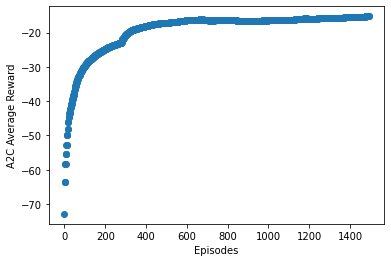

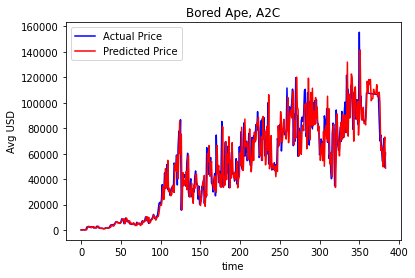

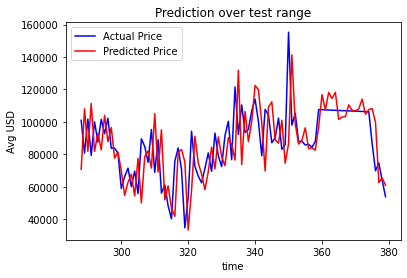

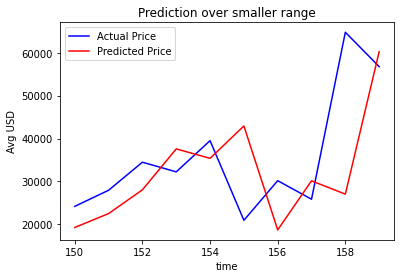

In [ ]:
data_file_directory_1 = '/content/drive/MyDrive/NFT Prediction/bored_ape_FINAL.csv'
test_env = NFT_Price_Gym(data_file_directory_1, train=False)
file_directory = '/content/drive/My Drive/NFT Prediction/training/bored ape/agent_A2C_FINAL/150000/best_model.zip'
model = A2C.load(file_directory, test_env)

obs = test_env.reset()

# Plotting Average Reward throughout training
reward_list = Callbacktinst.reward_list[5:]
rewards = np.array(reward_list)
episodes= np.array(range(len(reward_list)))
plt.scatter(episodes, rewards)
plt.xlabel('Episodes')
plt.ylabel('A2C Average Reward')

plt.show()

obs = test_env.reset()

done = False
pred_list = []
gt_list = []

while not done:
    action, _ = model.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    prediction = test_env.agent_prediction
    pred_list.append(prediction)
    gt = obs[1]
    gt_list.append(gt)

# Plotting prediction over total range
time1 = np.array(range(len(gt_list)))

plt.plot(time1, gt_list, color='blue', label='Actual Price')
plt.plot(time1, pred_list, color='red', label='Predicted Price')
plt.title('Bored Ape, A2C')
plt.xlabel('time')
plt.ylabel('Avg USD')
plt.legend()
plt.show()

# Plotting over test range
tot_time = len(gt_list)
plot_range = int(tot_time*0.24)
start = int(tot_time*0.75)
time = start + np.array(range(plot_range))

plt.plot(time, gt_list[start:start+plot_range], color='blue', label='Actual Price')
plt.plot(time, pred_list[start:start+plot_range], color='red', label='Predicted Price')
plt.title('Prediction over test range')
plt.xlabel('time')
plt.ylabel('Avg USD')
plt.legend()
plt.show()

# Plotting over smaller range
plot_range = 10
start = 150
time = start + np.array(range(plot_range))

plt.plot(time, gt_list[start:start+plot_range], color='blue', label='Actual Price')
plt.plot(time, pred_list[start:start+plot_range], color='red', label='Predicted Price')
plt.title('Prediction over smaller range')
plt.xlabel('time')
plt.ylabel('Avg USD')
plt.legend()
plt.show()

In [ ]:
# Finding RMSE and R2

start_index = 300
RMSE = mean_squared_error(gt_list[start_index:], pred_list[start_index:], squared=False)
R2 = r2_score(gt_list[start_index:], pred_list[start_index:])

print('Bored Ape, A2C')
print('RMSE: {}'.format(RMSE))
print('R2: {}'.format(R2))


Bored Ape, A2C
RMSE: 19662.734042581218
R2: 0.11082038653062165


In [ ]:
# Axie Infinity
# PPO
data_file_directory_1 = '/content/drive/MyDrive/NFT Prediction/axie_infinity_final.csv'

filepath = "/content/drive/My Drive/NFT Prediction/training/axie infinity"
experiment = "agent_1"
log_dir = f"{filepath}/{experiment}"
file_directory = log_dir + '/best_model.zip'

train_env = NFT_Price_Gym(data_file_directory_1, train=True)
train_env = Monitor(train_env, log_dir)

Callbacktinst = SaveonBestandProgressBar(check_freq=2000, log_dir=log_dir)

# The default MlpPolicy of SB3 for PPO and A2C uses tanh as its activation function
model = PPO("MlpPolicy", train_env, verbose=2)
num_timesteps = 1.5e5
model.learn(num_timesteps, callback=Callbacktinst, eval_freq=1000, log_interval=1000)

Using cpu device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


  0%|          | 0/151552 [00:00<?, ?it/s]

Num timesteps: 2000
Best mean reward: -inf - Last mean reward per episode: -40.72
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/2000/best_model
Num timesteps: 4000
Best mean reward: -40.72 - Last mean reward per episode: -16.03
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/4000/best_model
Num timesteps: 6000
Best mean reward: -16.03 - Last mean reward per episode: -11.03
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/6000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/6000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 8000
Best mean reward: -11.03 - Last mean reward per episode: -8.89
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/8000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/8000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 10000
Best mean reward: -8.89 - Last mean reward per episode: -8.25
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/10000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/10000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 12000
Best mean reward: -8.25 - Last mean reward per episode: -7.35
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/12000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/12000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 14000
Best mean reward: -7.35 - Last mean reward per episode: -6.76
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/14000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/14000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 16000
Best mean reward: -6.76 - Last mean reward per episode: -6.31
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/16000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/16000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 18000
Best mean reward: -6.31 - Last mean reward per episode: -6.11
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/18000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/18000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 20000
Best mean reward: -6.11 - Last mean reward per episode: -5.81
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/20000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/20000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 22000
Best mean reward: -5.81 - Last mean reward per episode: -5.57
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/22000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/22000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 24000
Best mean reward: -5.57 - Last mean reward per episode: -5.39
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/24000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/24000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 26000
Best mean reward: -5.39 - Last mean reward per episode: -5.30
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/26000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/26000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 28000
Best mean reward: -5.30 - Last mean reward per episode: -5.16
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/28000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/28000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 30000
Best mean reward: -5.16 - Last mean reward per episode: -5.02
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/30000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/30000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 32000
Best mean reward: -5.02 - Last mean reward per episode: -4.91
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/32000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/32000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 34000
Best mean reward: -4.91 - Last mean reward per episode: -4.81
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/34000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/34000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 36000
Best mean reward: -4.81 - Last mean reward per episode: -4.78
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/36000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/36000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 38000
Best mean reward: -4.78 - Last mean reward per episode: -4.71
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/38000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/38000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 40000
Best mean reward: -4.71 - Last mean reward per episode: -4.62
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/40000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/40000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 42000
Best mean reward: -4.62 - Last mean reward per episode: -4.55
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/42000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/42000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 44000
Best mean reward: -4.55 - Last mean reward per episode: -4.54
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/44000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/44000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 46000
Best mean reward: -4.54 - Last mean reward per episode: -4.50
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/46000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/46000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 48000
Best mean reward: -4.50 - Last mean reward per episode: -4.46
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/48000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/48000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 50000
Best mean reward: -4.46 - Last mean reward per episode: -4.42
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/50000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/50000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 52000
Best mean reward: -4.42 - Last mean reward per episode: -4.39
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/52000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/52000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 54000
Best mean reward: -4.39 - Last mean reward per episode: -4.34
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/54000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/54000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 56000
Best mean reward: -4.34 - Last mean reward per episode: -4.29
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/56000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/56000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 58000
Best mean reward: -4.29 - Last mean reward per episode: -4.24
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/58000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/58000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 60000
Best mean reward: -4.24 - Last mean reward per episode: -4.22
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/60000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/60000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 62000
Best mean reward: -4.22 - Last mean reward per episode: -4.19
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/62000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/62000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 64000
Best mean reward: -4.19 - Last mean reward per episode: -4.15
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/64000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/64000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 66000
Best mean reward: -4.15 - Last mean reward per episode: -4.12
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/66000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/66000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 68000
Best mean reward: -4.12 - Last mean reward per episode: -4.09
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/68000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/68000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 70000
Best mean reward: -4.09 - Last mean reward per episode: -4.08
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/70000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/70000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 72000
Best mean reward: -4.08 - Last mean reward per episode: -4.06
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/72000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/72000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 74000
Best mean reward: -4.06 - Last mean reward per episode: -4.03
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/74000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/74000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 76000
Best mean reward: -4.03 - Last mean reward per episode: -4.01
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/76000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/76000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 78000
Best mean reward: -4.01 - Last mean reward per episode: -3.99
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/78000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/78000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 80000
Best mean reward: -3.99 - Last mean reward per episode: -3.98
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/80000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/80000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 82000
Best mean reward: -3.98 - Last mean reward per episode: -3.97
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/82000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/82000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 84000
Best mean reward: -3.97 - Last mean reward per episode: -3.97
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/84000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/84000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 86000
Best mean reward: -3.97 - Last mean reward per episode: -3.95
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/86000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/86000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 88000
Best mean reward: -3.95 - Last mean reward per episode: -3.95
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/88000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/88000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 90000
Best mean reward: -3.95 - Last mean reward per episode: -3.93
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/90000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/90000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 92000
Best mean reward: -3.93 - Last mean reward per episode: -3.91
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/92000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/92000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 94000
Best mean reward: -3.91 - Last mean reward per episode: -3.90
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/94000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/94000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 96000
Best mean reward: -3.90 - Last mean reward per episode: -3.88
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/96000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/96000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 98000
Best mean reward: -3.88 - Last mean reward per episode: -3.86
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/98000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/98000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 100000
Best mean reward: -3.86 - Last mean reward per episode: -3.84
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/100000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/100000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 102000
Best mean reward: -3.84 - Last mean reward per episode: -3.82
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/102000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/102000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 104000
Best mean reward: -3.82 - Last mean reward per episode: -3.82
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/104000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/104000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 106000
Best mean reward: -3.82 - Last mean reward per episode: -3.80
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/106000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/106000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 108000
Best mean reward: -3.80 - Last mean reward per episode: -3.78
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/108000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/108000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 110000
Best mean reward: -3.78 - Last mean reward per episode: -3.77
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/110000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/110000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 112000
Best mean reward: -3.77 - Last mean reward per episode: -3.76
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/112000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/112000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 114000
Best mean reward: -3.76 - Last mean reward per episode: -3.75
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/114000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/114000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 116000
Best mean reward: -3.75 - Last mean reward per episode: -3.37
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/116000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/116000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 118000
Best mean reward: -3.37 - Last mean reward per episode: -3.36
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/118000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/118000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 120000
Best mean reward: -3.36 - Last mean reward per episode: -3.36
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/120000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/120000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 122000
Best mean reward: -3.36 - Last mean reward per episode: -3.35
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/122000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/122000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 124000
Best mean reward: -3.35 - Last mean reward per episode: -3.33
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/124000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/124000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 126000
Best mean reward: -3.33 - Last mean reward per episode: -3.32
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/126000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/126000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 128000
Best mean reward: -3.32 - Last mean reward per episode: -3.31
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/128000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/128000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 130000
Best mean reward: -3.31 - Last mean reward per episode: -3.30
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/130000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/130000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 132000
Best mean reward: -3.30 - Last mean reward per episode: -3.29
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/132000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/132000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 134000
Best mean reward: -3.29 - Last mean reward per episode: -3.28
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/134000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/134000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 136000
Best mean reward: -3.28 - Last mean reward per episode: -3.27
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/136000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/136000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 138000
Best mean reward: -3.27 - Last mean reward per episode: -3.27
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/138000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/138000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 140000
Best mean reward: -3.27 - Last mean reward per episode: -3.25
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/140000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/140000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 142000
Best mean reward: -3.25 - Last mean reward per episode: -3.25
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/142000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/142000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 144000
Best mean reward: -3.25 - Last mean reward per episode: -3.24
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/144000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/144000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 146000
Best mean reward: -3.24 - Last mean reward per episode: -3.24
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/146000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/146000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 148000
Best mean reward: -3.24 - Last mean reward per episode: -3.22
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/148000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/148000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 150000
Best mean reward: -3.22 - Last mean reward per episode: -3.21
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/150000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/150000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


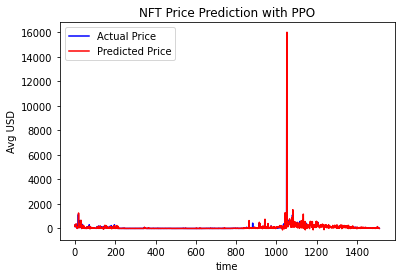

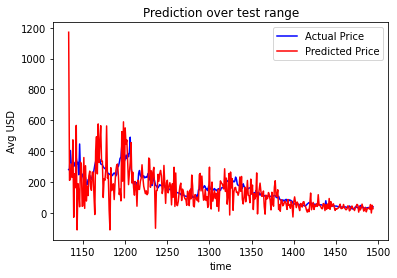

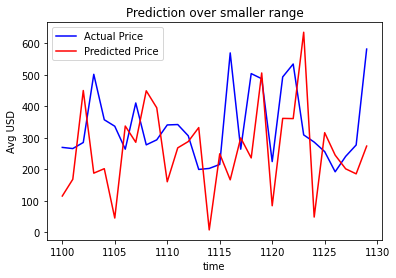

In [ ]:
data_file_directory_1 = '/content/drive/MyDrive/NFT Prediction/axie_infinity_final.csv'
test_env = NFT_Price_Gym(data_file_directory_1, train=False)
file_directory = '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_1/150000/best_model'
model = PPO.load(file_directory, test_env)

obs = test_env.reset()

done = False
pred_list_PPO = []
gt_list_PPO = []

while not done:
    action, _ = model.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    prediction = test_env.agent_prediction
    pred_list_PPO.append(prediction)
    gt = obs[1]
    gt_list_PPO.append(gt)

# Plotting prediction over total range
time1 = np.array(range(len(gt_list_PPO)))

plt.plot(time1, gt_list_PPO, color='blue', label='Actual Price')
plt.plot(time1, pred_list_PPO, color='red', label='Predicted Price')
plt.title('Axie Infinity, PPO')
plt.xlabel('time')
plt.ylabel('Avg USD')
plt.legend()
plt.show()

# Plotting over test range
tot_time = len(gt_list_PPO)
plot_range = int(tot_time*0.24)
start = int(tot_time*0.75)
time = start + np.array(range(plot_range))

plt.plot(time, gt_list_PPO[start:start+plot_range], color='blue', label='Actual Price')
plt.plot(time, pred_list_PPO[start:start+plot_range], color='red', label='Predicted Price')
plt.title('Prediction over test range')
plt.xlabel('time')
plt.ylabel('Avg USD')
plt.legend()
plt.show()

# Plotting over smaller range
plot_range = 30
start = 1100
time = start + np.array(range(plot_range))

plt.plot(time, gt_list_PPO[start:start+plot_range], color='blue', label='Actual Price')
plt.plot(time, pred_list_PPO[start:start+plot_range], color='red', label='Predicted Price')
plt.title('Prediction over smaller range')
plt.xlabel('time')
plt.ylabel('Avg USD')
plt.legend()
plt.show()

In [ ]:
# Finding RMSE and R2

start_index = int(tot_time*0.75)
RMSE = mean_squared_error(gt_list_PPO[start_index:], pred_list_PPO[start_index:], squared=False)
R2 = r2_score(gt_list_PPO[start_index:], pred_list_PPO[start_index:])

print('Axie Infinity, PPO')
print('RMSE: {:.3f}'.format(RMSE))
print('R2: {:.3f}'.format(R2))

Axie Infinity, PPO
RMSE: 100.979
R2: -0.041


In [ ]:
# A2C

filepath = "/content/drive/My Drive/NFT Prediction/training/axie infinity"
experiment = "agent_A2C"
log_dir = f"{filepath}/{experiment}"
file_directory = log_dir + '/best_model.zip'

train_env = NFT_Price_Gym(data_file_directory_1, train=True)
train_env = Monitor(train_env, log_dir)

Callbacktinst = SaveonBestandProgressBar(check_freq=2000, log_dir=log_dir)

model = A2C("MlpPolicy", train_env, verbose=2)
num_timesteps = 1.5e5
model.learn(num_timesteps, callback=Callbacktinst, eval_freq=1000, log_interval=1000)

Using cpu device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


  0%|          | 0/150000 [00:00<?, ?it/s]

Num timesteps: 2000
Best mean reward: -inf - Last mean reward per episode: -40.32
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/2000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/2000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 4000
Best mean reward: -40.32 - Last mean reward per episode: -15.28
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/4000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/4000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -12.2    |
| time/                 |          |
|    fps                | 192      |
|    iterations         | 1000     |
|    time_elapsed       | 25       |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -1.42    |
|    explained_variance | -6.21    |
|    learning_rate      | 0.0007   |
|    n_updates          | 999      |
|    policy_loss        | -0.00956 |
|    std                | 1        |
|    value_loss         | 5.6e-05  |
------------------------------------
Num timesteps: 6000
Best mean reward: -15.28 - Last mean reward per episode: -10.33
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/6000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/6000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 8000
Best mean reward: -10.33 - Last mean reward per episode: -8.26
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/8000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/8000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 10000
Best mean reward: -8.26 - Last mean reward per episode: -7.60
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/10000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -7.6     |
| time/                 |          |
|    fps                | 129      |
|    iterations         | 2000     |
|    time_elapsed       | 77       |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -1.43    |
|    explained_variance | -3.38    |
|    learning_rate      | 0.0007   |
|    n_updates          | 1999     |
|    policy_loss        | -0.0818  |
|    std                | 1.01     |
|    value_loss         | 0.00356  |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/10000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 12000
Best mean reward: -7.60 - Last mean reward per episode: -6.67
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/12000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/12000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 14000
Best mean reward: -6.67 - Last mean reward per episode: -6.00
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/14000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/14000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -5.75    |
| time/                 |          |
|    fps                | 113      |
|    iterations         | 3000     |
|    time_elapsed       | 132      |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -1.38    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 2999     |
|    policy_loss        | 0.00412  |
|    std                | 0.959    |
|    value_loss         | 1.07e-05 |
------------------------------------
Num timesteps: 16000
Best mean reward: -6.00 - Last mean reward per episode: -5.54
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/16000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/16000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 18000
Best mean reward: -5.54 - Last mean reward per episode: -5.35
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/18000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/18000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 20000
Best mean reward: -5.35 - Last mean reward per episode: -5.04
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/20000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -5.04    |
| time/                 |          |
|    fps                | 117      |
|    iterations         | 4000     |
|    time_elapsed       | 170      |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -1.33    |
|    explained_variance | -20.2    |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | 0.00761  |
|    std                | 0.917    |
|    value_loss         | 2.87e-05 |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/20000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 22000
Best mean reward: -5.04 - Last mean reward per episode: -4.83
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/22000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/22000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 24000
Best mean reward: -4.83 - Last mean reward per episode: -4.63
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/24000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/24000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -4.54    |
| time/                 |          |
|    fps                | 117      |
|    iterations         | 5000     |
|    time_elapsed       | 213      |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -1.27    |
|    explained_variance | -31.1    |
|    learning_rate      | 0.0007   |
|    n_updates          | 4999     |
|    policy_loss        | 0.0013   |
|    std                | 0.865    |
|    value_loss         | 6.22e-05 |
------------------------------------
Num timesteps: 26000
Best mean reward: -4.63 - Last mean reward per episode: -4.54
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/26000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/26000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 28000
Best mean reward: -4.54 - Last mean reward per episode: -4.41
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/28000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/28000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 30000
Best mean reward: -4.41 - Last mean reward per episode: -4.31
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/30000/best_model
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 1.13e+03  |
|    ep_rew_mean        | -4.31     |
| time/                 |           |
|    fps                | 113       |
|    iterations         | 6000      |
|    time_elapsed       | 263       |
|    total_timesteps    | 30000     |
| train/                |           |
|    entropy_loss       | -1.24     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 5999      |
|    policy_loss        | -0.000811 |
|    std                | 0.834     |
|    value_loss         | 6.38e-07  |
-------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/30000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 32000
Best mean reward: -4.31 - Last mean reward per episode: -4.22
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/32000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/32000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 34000
Best mean reward: -4.22 - Last mean reward per episode: -4.11
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/34000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/34000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -4.11    |
| time/                 |          |
|    fps                | 109      |
|    iterations         | 7000     |
|    time_elapsed       | 319      |
|    total_timesteps    | 35000    |
| train/                |          |
|    entropy_loss       | -1.21    |
|    explained_variance | -14.2    |
|    learning_rate      | 0.0007   |
|    n_updates          | 6999     |
|    policy_loss        | -0.0225  |
|    std                | 0.812    |
|    value_loss         | 0.000568 |
------------------------------------
Num timesteps: 36000
Best mean reward: -4.11 - Last mean reward per episode: -4.05
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/36000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/36000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 38000
Best mean reward: -4.05 - Last mean reward per episode: -4.00
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/38000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/38000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 40000
Best mean reward: -4.00 - Last mean reward per episode: -3.93
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/40000/best_model
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 1.13e+03  |
|    ep_rew_mean        | -3.93     |
| time/                 |           |
|    fps                | 104       |
|    iterations         | 8000      |
|    time_elapsed       | 381       |
|    total_timesteps    | 40000     |
| train/                |           |
|    entropy_loss       | -1.17     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 7999      |
|    policy_loss        | -6.8e-05  |
|    std                | 0.78      |
|    value_loss         | 9.59e-09  |
-------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/40000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 42000
Best mean reward: -3.93 - Last mean reward per episode: -3.87
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/42000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/42000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 44000
Best mean reward: -3.87 - Last mean reward per episode: -3.84
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/44000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/44000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 1.13e+03  |
|    ep_rew_mean        | -3.82     |
| time/                 |           |
|    fps                | 100       |
|    iterations         | 9000      |
|    time_elapsed       | 448       |
|    total_timesteps    | 45000     |
| train/                |           |
|    entropy_loss       | -1.14     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 8999      |
|    policy_loss        | -0.000296 |
|    std                | 0.755     |
|    value_loss         | 8.05e-08  |
-------------------------------------
Num timesteps: 46000
Best mean reward: -3.84 - Last mean reward per episode: -3.80
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/46000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/46000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 48000
Best mean reward: -3.80 - Last mean reward per episode: -3.74
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/48000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/48000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 50000
Best mean reward: -3.74 - Last mean reward per episode: -3.69
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/50000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -3.69    |
| time/                 |          |
|    fps                | 96       |
|    iterations         | 10000    |
|    time_elapsed       | 516      |
|    total_timesteps    | 50000    |
| train/                |          |
|    entropy_loss       | -1.12    |
|    explained_variance | -7.04    |
|    learning_rate      | 0.0007   |
|    n_updates          | 9999     |
|    policy_loss        | 0.00155  |
|    std                | 0.744    |
|    value_loss         | 1.52e-05 |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/50000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 52000
Best mean reward: -3.69 - Last mean reward per episode: -3.67
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/52000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/52000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 54000
Best mean reward: -3.67 - Last mean reward per episode: -3.62
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/54000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/54000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -3.59    |
| time/                 |          |
|    fps                | 93       |
|    iterations         | 11000    |
|    time_elapsed       | 589      |
|    total_timesteps    | 55000    |
| train/                |          |
|    entropy_loss       | -1.08    |
|    explained_variance | -39      |
|    learning_rate      | 0.0007   |
|    n_updates          | 10999    |
|    policy_loss        | 0.00359  |
|    std                | 0.715    |
|    value_loss         | 3.77e-05 |
------------------------------------
Num timesteps: 56000
Best mean reward: -3.62 - Last mean reward per episode: -3.57
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/56000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/56000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 58000
Best mean reward: -3.57 - Last mean reward per episode: -3.55
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/58000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/58000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 60000
Best mean reward: -3.55 - Last mean reward per episode: -3.53
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/60000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -3.53    |
| time/                 |          |
|    fps                | 89       |
|    iterations         | 12000    |
|    time_elapsed       | 666      |
|    total_timesteps    | 60000    |
| train/                |          |
|    entropy_loss       | -1.04    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 11999    |
|    policy_loss        | 0.00359  |
|    std                | 0.683    |
|    value_loss         | 1.86e-05 |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/60000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 62000
Best mean reward: -3.53 - Last mean reward per episode: -3.50
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/62000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/62000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 64000
Best mean reward: -3.50 - Last mean reward per episode: -3.48
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/64000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/64000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -3.47    |
| time/                 |          |
|    fps                | 86       |
|    iterations         | 13000    |
|    time_elapsed       | 749      |
|    total_timesteps    | 65000    |
| train/                |          |
|    entropy_loss       | -0.991   |
|    explained_variance | -12.4    |
|    learning_rate      | 0.0007   |
|    n_updates          | 12999    |
|    policy_loss        | 0.00341  |
|    std                | 0.652    |
|    value_loss         | 4.47e-05 |
------------------------------------
Num timesteps: 66000
Best mean reward: -3.48 - Last mean reward per episode: -3.45
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/66000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/66000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 68000
Best mean reward: -3.45 - Last mean reward per episode: -3.43
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/68000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/68000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 70000
Best mean reward: -3.43 - Last mean reward per episode: -3.42
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/70000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -3.42    |
| time/                 |          |
|    fps                | 83       |
|    iterations         | 14000    |
|    time_elapsed       | 834      |
|    total_timesteps    | 70000    |
| train/                |          |
|    entropy_loss       | -0.971   |
|    explained_variance | -4.55    |
|    learning_rate      | 0.0007   |
|    n_updates          | 13999    |
|    policy_loss        | 0.0368   |
|    std                | 0.64     |
|    value_loss         | 0.000684 |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/70000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 72000
Best mean reward: -3.42 - Last mean reward per episode: -3.39
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/72000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/72000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 74000
Best mean reward: -3.39 - Last mean reward per episode: -3.37
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/74000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/74000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -3.36    |
| time/                 |          |
|    fps                | 81       |
|    iterations         | 15000    |
|    time_elapsed       | 924      |
|    total_timesteps    | 75000    |
| train/                |          |
|    entropy_loss       | -0.95    |
|    explained_variance | -0.129   |
|    learning_rate      | 0.0007   |
|    n_updates          | 14999    |
|    policy_loss        | 0.0033   |
|    std                | 0.626    |
|    value_loss         | 2.76e-05 |
------------------------------------
Num timesteps: 76000
Best mean reward: -3.37 - Last mean reward per episode: -3.36
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/76000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/76000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 78000
Best mean reward: -3.36 - Last mean reward per episode: -3.34
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/78000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/78000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 80000
Best mean reward: -3.34 - Last mean reward per episode: -3.32
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/80000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -3.32    |
| time/                 |          |
|    fps                | 78       |
|    iterations         | 16000    |
|    time_elapsed       | 1020     |
|    total_timesteps    | 80000    |
| train/                |          |
|    entropy_loss       | -0.9     |
|    explained_variance | -5.88    |
|    learning_rate      | 0.0007   |
|    n_updates          | 15999    |
|    policy_loss        | -0.00193 |
|    std                | 0.595    |
|    value_loss         | 2.66e-06 |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/80000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 82000
Best mean reward: -3.32 - Last mean reward per episode: -3.30
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/82000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/82000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 84000
Best mean reward: -3.30 - Last mean reward per episode: -3.28
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/84000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/84000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -3.27    |
| time/                 |          |
|    fps                | 75       |
|    iterations         | 17000    |
|    time_elapsed       | 1121     |
|    total_timesteps    | 85000    |
| train/                |          |
|    entropy_loss       | -0.896   |
|    explained_variance | -0.481   |
|    learning_rate      | 0.0007   |
|    n_updates          | 16999    |
|    policy_loss        | -0.0559  |
|    std                | 0.592    |
|    value_loss         | 0.00345  |
------------------------------------
Num timesteps: 86000
Best mean reward: -3.28 - Last mean reward per episode: -3.27
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/86000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/86000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 88000
Best mean reward: -3.27 - Last mean reward per episode: -3.25
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/88000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/88000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 90000
Best mean reward: -3.25 - Last mean reward per episode: -3.23
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/90000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -3.23    |
| time/                 |          |
|    fps                | 73       |
|    iterations         | 18000    |
|    time_elapsed       | 1227     |
|    total_timesteps    | 90000    |
| train/                |          |
|    entropy_loss       | -0.876   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 17999    |
|    policy_loss        | 0.000212 |
|    std                | 0.581    |
|    value_loss         | 1.99e-07 |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/90000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 92000
Best mean reward: -3.23 - Last mean reward per episode: -3.21
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/92000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/92000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 94000
Best mean reward: -3.21 - Last mean reward per episode: -3.20
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/94000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/94000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -3.19    |
| time/                 |          |
|    fps                | 70       |
|    iterations         | 19000    |
|    time_elapsed       | 1351     |
|    total_timesteps    | 95000    |
| train/                |          |
|    entropy_loss       | -0.883   |
|    explained_variance | -0.255   |
|    learning_rate      | 0.0007   |
|    n_updates          | 18999    |
|    policy_loss        | 0.0032   |
|    std                | 0.585    |
|    value_loss         | 3.82e-05 |
------------------------------------
Num timesteps: 96000
Best mean reward: -3.20 - Last mean reward per episode: -3.18
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/96000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/96000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 98000
Best mean reward: -3.18 - Last mean reward per episode: -3.18
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/98000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/98000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 100000
Best mean reward: -3.18 - Last mean reward per episode: -3.16
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/100000/best_model
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 1.13e+03  |
|    ep_rew_mean        | -3.16     |
| time/                 |           |
|    fps                | 67        |
|    iterations         | 20000     |
|    time_elapsed       | 1488      |
|    total_timesteps    | 100000    |
| train/                |           |
|    entropy_loss       | -0.866    |
|    explained_variance | -215      |
|    learning_rate      | 0.0007    |
|    n_updates          | 19999     |
|    policy_loss        | -0.000159 |
|    std                | 0.576     |
|    value_loss         | 4.3e-06   |
-------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/100000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 102000
Best mean reward: -3.16 - Last mean reward per episode: -3.14
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/102000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/102000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 104000
Best mean reward: -3.14 - Last mean reward per episode: -3.14
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/104000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/104000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -3.13    |
| time/                 |          |
|    fps                | 64       |
|    iterations         | 21000    |
|    time_elapsed       | 1636     |
|    total_timesteps    | 105000   |
| train/                |          |
|    entropy_loss       | -0.842   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 20999    |
|    policy_loss        | 0.000573 |
|    std                | 0.561    |
|    value_loss         | 2.37e-07 |
------------------------------------
Num timesteps: 106000
Best mean reward: -3.14 - Last mean reward per episode: -3.13
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/106000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/106000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 108000
Best mean reward: -3.13 - Last mean reward per episode: -3.12
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/108000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/108000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 110000
Best mean reward: -3.12 - Last mean reward per episode: -3.11
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/110000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -3.11    |
| time/                 |          |
|    fps                | 61       |
|    iterations         | 22000    |
|    time_elapsed       | 1780     |
|    total_timesteps    | 110000   |
| train/                |          |
|    entropy_loss       | -0.817   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 21999    |
|    policy_loss        | 0.00548  |
|    std                | 0.548    |
|    value_loss         | 0.000101 |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/110000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 112000
Best mean reward: -3.11 - Last mean reward per episode: -3.10
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/112000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/112000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 114000
Best mean reward: -3.10 - Last mean reward per episode: -3.09
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/114000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/114000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -2.72    |
| time/                 |          |
|    fps                | 59       |
|    iterations         | 23000    |
|    time_elapsed       | 1927     |
|    total_timesteps    | 115000   |
| train/                |          |
|    entropy_loss       | -0.802   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 22999    |
|    policy_loss        | 0.000347 |
|    std                | 0.54     |
|    value_loss         | 2.15e-07 |
------------------------------------
Num timesteps: 116000
Best mean reward: -3.09 - Last mean reward per episode: -2.72
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/116000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/116000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 118000
Best mean reward: -2.72 - Last mean reward per episode: -2.71
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/118000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/118000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 120000
Best mean reward: -2.71 - Last mean reward per episode: -2.71
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/120000/best_model
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -2.71    |
| time/                 |          |
|    fps                | 57       |
|    iterations         | 24000    |
|    time_elapsed       | 2073     |
|    total_timesteps    | 120000   |
| train/                |          |
|    entropy_loss       | -0.785   |
|    explained_variance | -809     |
|    learning_rate      | 0.0007   |
|    n_updates          | 23999    |
|    policy_loss        | -0.0104  |
|    std                | 0.531    |
|    value_loss         | 0.000699 |
------------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/120000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 122000
Best mean reward: -2.71 - Last mean reward per episode: -2.70
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/122000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/122000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 124000
Best mean reward: -2.70 - Last mean reward per episode: -2.69
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/124000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/124000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -2.69    |
| time/                 |          |
|    fps                | 55       |
|    iterations         | 25000    |
|    time_elapsed       | 2263     |
|    total_timesteps    | 125000   |
| train/                |          |
|    entropy_loss       | -0.779   |
|    explained_variance | -388     |
|    learning_rate      | 0.0007   |
|    n_updates          | 24999    |
|    policy_loss        | 0.00568  |
|    std                | 0.527    |
|    value_loss         | 0.000174 |
------------------------------------
Num timesteps: 126000
Best mean reward: -2.69 - Last mean reward per episode: -2.70
Num timesteps: 128000
Best mean reward: -2.69 - Last mean reward per episode: -2.70
Num timesteps: 130000
Best mean reward: -2.69 - Last mean reward per episode: -2.70
-------------------------------------
| rollout/              |           |
|    e

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/134000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -2.69    |
| time/                 |          |
|    fps                | 51       |
|    iterations         | 27000    |
|    time_elapsed       | 2604     |
|    total_timesteps    | 135000   |
| train/                |          |
|    entropy_loss       | -0.779   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 26999    |
|    policy_loss        | 0.00269  |
|    std                | 0.527    |
|    value_loss         | 3.85e-05 |
------------------------------------
Num timesteps: 136000
Best mean reward: -2.69 - Last mean reward per episode: -2.69
Num timesteps: 138000
Best mean reward: -2.69 - Last mean reward per episode: -2.69
Saving new best model to /content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/138000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/138000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 140000
Best mean reward: -2.69 - Last mean reward per episode: -2.69
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.13e+03 |
|    ep_rew_mean        | -2.69    |
| time/                 |          |
|    fps                | 50       |
|    iterations         | 28000    |
|    time_elapsed       | 2751     |
|    total_timesteps    | 140000   |
| train/                |          |
|    entropy_loss       | -0.783   |
|    explained_variance | -16.5    |
|    learning_rate      | 0.0007   |
|    n_updates          | 27999    |
|    policy_loss        | 1.81e-05 |
|    std                | 0.53     |
|    value_loss         | 6.88e-07 |
------------------------------------
Num timesteps: 142000
Best mean reward: -2.69 - Last mean reward per episode: -2.70
Num timesteps: 144000
Best mean reward: -2.69 - Last mean reward per episode: -2.72
------------------------------------
| rollout/              |          |
|    ep_

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


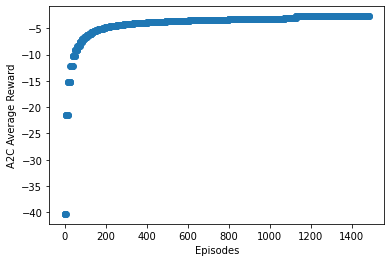

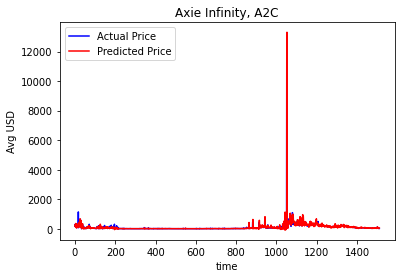

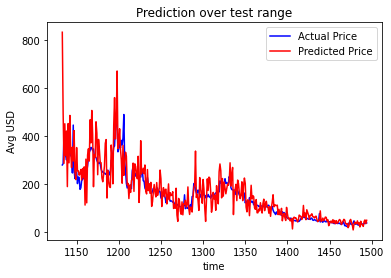

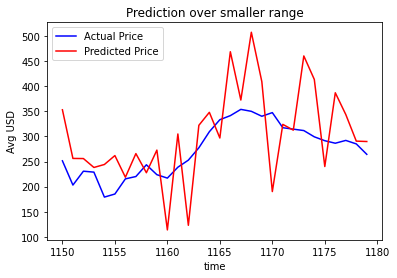

In [ ]:
data_file_directory_1 = '/content/drive/MyDrive/NFT Prediction/axie_infinity_final.csv'
test_env = NFT_Price_Gym(data_file_directory_1, train=False)
file_directory = '/content/drive/My Drive/NFT Prediction/training/axie infinity/agent_A2C/138000/best_model'
model = A2C.load(file_directory, test_env)

obs = test_env.reset()

# Plotting Average Reward throughout training
reward_list = Callbacktinst.reward_list[5:]
rewards = np.array(reward_list)
episodes= np.array(range(len(reward_list)))

plt.scatter(episodes, rewards)
plt.xlabel('Episodes')
plt.ylabel('A2C Average Reward')
plt.show()

done = False
pred_list = []
gt_list = []

while not done:
    action, _ = model.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    prediction = test_env.agent_prediction
    pred_list.append(prediction)
    gt = obs[1]
    gt_list.append(gt)

# Plotting prediction over total range
time1 = np.array(range(len(gt_list)))

plt.plot(time1, gt_list, color='blue', label='Actual Price')
plt.plot(time1, pred_list, color='red', label='Predicted Price')
plt.title('Axie Infinity, A2C')
plt.xlabel('time')
plt.ylabel('Avg USD')
plt.legend()
plt.show()

# Plotting over test range
tot_time = len(gt_list)
plot_range = int(tot_time*0.24)
start = int(tot_time*0.75)
time = start + np.array(range(plot_range))

plt.plot(time, gt_list[start:start+plot_range], color='blue', label='Actual Price')
plt.plot(time, pred_list[start:start+plot_range], color='red', label='Predicted Price')
plt.title('Prediction over test range')
plt.xlabel('time')
plt.ylabel('Avg USD')
plt.legend()
plt.show()

# Plotting over smaller range
plot_range = 30
start = 1150
time = start + np.array(range(plot_range))

plt.plot(time, gt_list[start:start+plot_range], color='blue', label='Actual Price')
plt.plot(time, pred_list[start:start+plot_range], color='red', label='Predicted Price')
plt.title('Prediction over smaller range')
plt.xlabel('time')
plt.ylabel('Avg USD')
plt.legend()
plt.show()

In [ ]:
# Finding RMSE and R2

start_index = int(tot_time*0.75)
RMSE = mean_squared_error(gt_list[start_index:], pred_list[start_index:], squared=False)
R2 = r2_score(gt_list[start_index:], pred_list[start_index:])

print('Axie Infinity, A2C')
print('RMSE: {}'.format(RMSE))
print('R2: {}'.format(R2))


Axie Infinity, A2C
RMSE: 24523.27349648863
R2: -0.5255227297780478
